In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

# 1. Load the Data (sql db)


In [2]:
con = sqlite3.connect("bmarket.db")

In [3]:
cursor = con.cursor()

        # Query the sqlite_master table to get table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        
        # Fetch all results
table_names = [row[0] for row in cursor.fetchall()]
print("Tables in the database:", table_names)

Tables in the database: ['bank_marketing']


In [4]:
query = "SELECT * FROM bank_marketing"
df = pd.read_sql_query(query, con)

con.close()

df.head()

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
0,32885,57 years,technician,married,high.school,no,no,yes,Cell,1,999,no
1,3170,55 years,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,32207,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,9404,36 years,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,14021,27 years,housemaid,married,high.school,no,None,no,Cell,2,999,no


# 2. Initial Data Understanding

We first need to inspect the dataset, to gain a better understanding of what we are working with.

This includes:\
-Number of rows & columns\
-Column names & data types\
-Summary of the statistics using .describe()\
-Outliers/Data quality issues

In [5]:
df.columns

Index(['Client ID', 'Age', 'Occupation', 'Marital Status', 'Education Level',
       'Credit Default', 'Housing Loan', 'Personal Loan', 'Contact Method',
       'Campaign Calls', 'Previous Contact Days', 'Subscription Status'],
      dtype='object')

In [6]:
df.shape

(41188, 12)

By looking at the results from "df.describe(include='all').T", we immediately make a few observations:\
-Under the 'top' result for the Age feature, it shows the highest age being 150 years old. As of now, the oldest person alive is 116 years old & the oldest ever recorded was 122. We need to dive into this later and verify the information


In [7]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Client ID,41188.0,NaN,NaN,NaN,20594.5,11890.09578,1.0,10297.75,20594.5,30891.25,41188.0
Age,41188,77,150 years,4197,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,41188,12,admin.,10422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital Status,41188,4,married,24928,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education Level,41188,8,university.degree,12168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit Default,41188,3,no,32588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Housing Loan,16399,3,yes,8595,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Personal Loan,37042,3,no,30532,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Contact Method,41188,4,Cell,13100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Campaign Calls,41188.0,NaN,NaN,NaN,2.051374,3.171345,-41.0,1.0,2.0,3.0,56.0


Insights from running .info()

There is column currently stored as the 'object' type, and needs to be changed:\
    -Age

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Client ID              41188 non-null  int64 
 1   Age                    41188 non-null  object
 2   Occupation             41188 non-null  object
 3   Marital Status         41188 non-null  object
 4   Education Level        41188 non-null  object
 5   Credit Default         41188 non-null  object
 6   Housing Loan           16399 non-null  object
 7   Personal Loan          37042 non-null  object
 8   Contact Method         41188 non-null  object
 9   Campaign Calls         41188 non-null  int64 
 10  Previous Contact Days  41188 non-null  int64 
 11  Subscription Status    41188 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.8+ MB


In [9]:
df.isna().sum()

Client ID                    0
Age                          0
Occupation                   0
Marital Status               0
Education Level              0
Credit Default               0
Housing Loan             24789
Personal Loan             4146
Contact Method               0
Campaign Calls               0
Previous Contact Days        0
Subscription Status          0
dtype: int64

Check the target column for distribution

Insights\
There is a very high class imbalance, hence we need to consider SMOTE or UnderSampling when training our model.


Subscription Status
no     0.887346
yes    0.112654
Name: count, dtype: float64

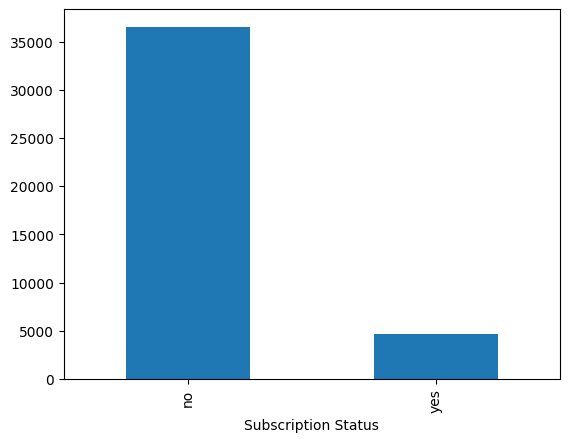

In [10]:
df['Subscription Status'].value_counts().plot(kind='bar')
df['Subscription Status'].value_counts()/df.shape[0]

### (2a) Column by Column Data Understanding & Insights

Data Understanding & Insights for Client ID\
From the description of Client ID, we can see that it is a unique identifier for each client.\
This indentifier column does not contain any missing values (41188 non-null values), which is equal to the total number of records in the dataset (41188).

In [11]:
display(df["Client ID"].nunique())
display(df["Client ID"].isna().sum())
display(df["Client ID"].describe())

41188

np.int64(0)

count    41188.00000
mean     20594.50000
std      11890.09578
min          1.00000
25%      10297.75000
50%      20594.50000
75%      30891.25000
max      41188.00000
Name: Client ID, dtype: float64

##### Data Understanding & Insights for Age
The "Age" feature in this dataset is stored as text, so it appears as an 'object' type.\
There are 77 unique ages\
The age "150 years" happens to appear in this dataset 4197 times, which is extremely unrealistic. The oldest person alive right now is 116 years old, which further solidifies the fact that there cannot be that many people who are significantly older.\
Hence, we will treat this value as an outlier\
The next oldest age after ""150 years" is "95 years", which is much more realistic.

In [12]:
display(df["Age"].dtype)
display(df["Age"].value_counts())

dtype('O')

Age
150 years    4197
31 years     1747
32 years     1646
33 years     1643
36 years     1606
             ... 
92 years        4
89 years        2
91 years        2
98 years        2
95 years        1
Name: count, Length: 77, dtype: int64

In [13]:
print("The number of unique ages is",df["Age"].nunique())

The number of unique ages is 77


In [14]:
display(df["Age"].value_counts().sort_index(ascending=False).head(10))
display(df["Age"].value_counts().sort_index(ascending=False).tail(10))

Age
98 years     2
95 years     1
92 years     4
91 years     2
89 years     2
88 years    19
86 years     8
85 years    15
84 years     7
83 years    16
Name: count, dtype: int64

Age
25 years      536
24 years      414
23 years      207
22 years      123
21 years       90
20 years       62
19 years       38
18 years       27
17 years        5
150 years    4197
Name: count, dtype: int64

##### Data Understanding & Insights for Occupation
This feature has a total of 12 different categories, with zero missing values.\
As this class is a categorial feature, we can use one-hot encoding.\
Later on during the bivariate analysis, we will be able to check how the different occupations can affect the subscription rates.

In [15]:
print("The number of occupations in this dataset is",df["Occupation"].nunique())
df["Occupation"].value_counts()

The number of occupations in this dataset is 12


Occupation
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

<class 'pandas.core.series.Series'>
RangeIndex: 41188 entries, 0 to 41187
Series name: Occupation
Non-Null Count  Dtype 
--------------  ----- 
41188 non-null  object
dtypes: object(1)
memory usage: 321.9+ KB


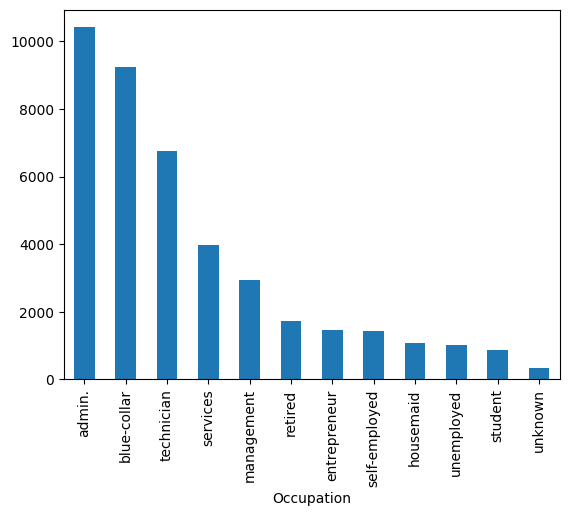

In [16]:
df['Occupation'].value_counts().plot(kind='bar')
df['Occupation'].info()
plt.show()

##### Data Understanding & Insights for Marital Status
This feature has a total of 4 different categories, with zero missing values.\
Similarly to the "Occupation" column, this class is a categorial feature, so we can use one-hot encoding.\
Later on during the bivariate analysis, we will be able to check how the different marital statuses can affect the subscription rates.\
It is particularly useful, as marital status can definitely influence financial decisions due to differing priorities and interests.

In [17]:
display(df["Marital Status"].value_counts())
display(df["Marital Status"].value_counts()/df.shape[0]*100)

Marital Status
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64

Marital Status
married     60.522482
single      28.085850
divorced    11.197436
unknown      0.194231
Name: count, dtype: float64

<class 'pandas.core.series.Series'>
RangeIndex: 41188 entries, 0 to 41187
Series name: Marital Status
Non-Null Count  Dtype 
--------------  ----- 
41188 non-null  object
dtypes: object(1)
memory usage: 321.9+ KB


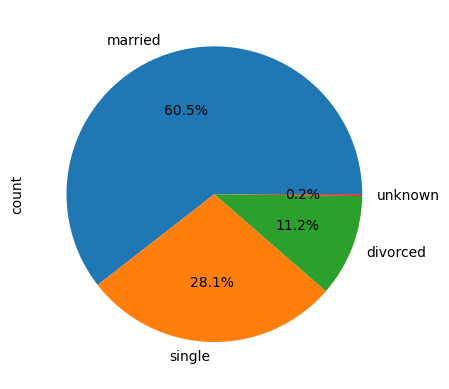

In [18]:
df['Marital Status'].value_counts().plot(kind='pie', autopct='%1.1f%%')
df['Marital Status'].info()
plt.show()

##### Data Understanding & Insights for Education Level
This feature has a total of 8 different categories, with zero missing values.\
This class is also a categorial feature, so we can use one-hot encoding.\
Later on during the bivariate analysis, we will be able to check how the different education levels can affect the subscription rates.\
Statistically, education generally correlates with income and financial literacy, which could affect the likelihood of individuals subscribing to the term deposit plan.

In [19]:
print("The number of different Education Levels in this dataset is",df["Education Level"].nunique())
df["Education Level"].value_counts()

The number of different Education Levels in this dataset is 8


Education Level
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

<class 'pandas.core.series.Series'>
RangeIndex: 41188 entries, 0 to 41187
Series name: Education Level
Non-Null Count  Dtype 
--------------  ----- 
41188 non-null  object
dtypes: object(1)
memory usage: 321.9+ KB


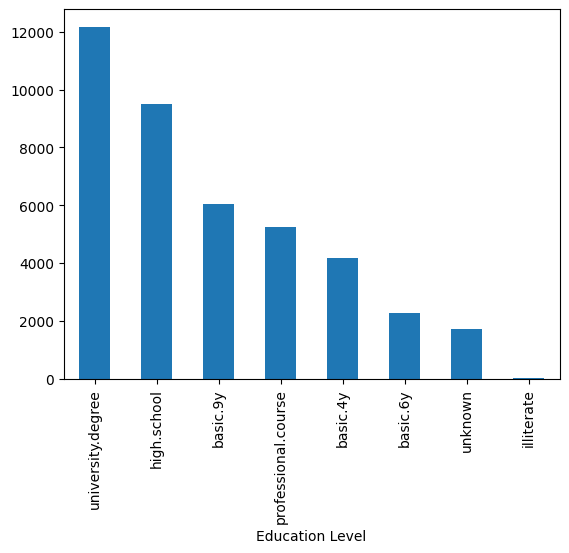

In [20]:
df['Education Level'].value_counts().plot(kind='bar')
df['Education Level'].info()
plt.show()

##### Data Understanding & Insights for Credit Default
This feature has a total of 3 different categories, with zero missing values. However there is a decently large number of the "unknown" class\
There is an extreme imbalance of data for this column, as seen below, where there are only three instances of "yes", which is 0.007% of the data.\
We will need to consider how we use the "yes" class later on, due to its scarcity.

In [21]:
display(df["Credit Default"].value_counts())
display(df["Credit Default"].value_counts()/df.shape[0]*100)

Credit Default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

Credit Default
no         79.120132
unknown    20.872584
yes         0.007284
Name: count, dtype: float64

##### Data Understanding & Insights for Housing Loan
This feature has a total of 3 different categories.\
There is a large number of null values for this column (24789), which is ~60% of the data.\
We will need to consider how we classify the null values later on, due to how much of the data it constitutes.

In [22]:
display(df["Housing Loan"].isna().sum())
display(df["Housing Loan"].isna().sum()/df.shape[0]*100)
display(df["Housing Loan"].value_counts())

np.int64(24789)

np.float64(60.18500534136157)

Housing Loan
yes        8595
no         7411
unknown     393
Name: count, dtype: int64

##### Data Understanding & Insights for Personal Loan
This feature has a total of 3 different categories.\
Similar to the previous column, Housing Loan, there are null values for this column (4146), which is ~10% of the data.\
This feature will be useful as having personal loan(s) could indicate that the person already has financial commitments and this could reduce the likeliness of them subscribing to a new term deposit.
We will need to consider how we classify the null values later on.

np.int64(4146)

np.float64(10.066038652034573)

Personal Loan
no         30532
yes         5633
unknown      877
Name: count, dtype: int64

Personal Loan
no         74.128387
yes        13.676313
unknown     2.129261
Name: count, dtype: float64

<Axes: xlabel='Personal Loan'>

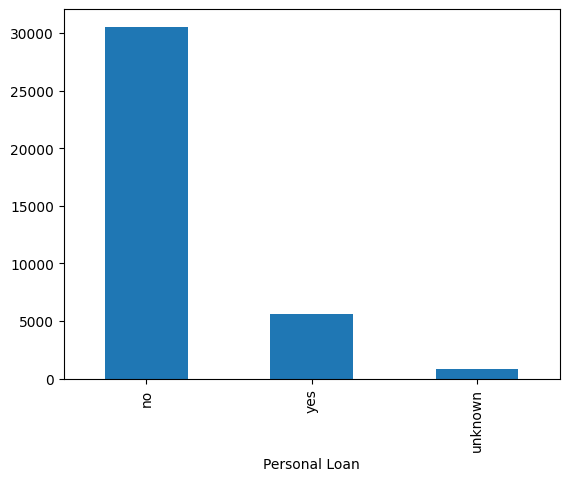

In [23]:
display(df["Personal Loan"].isna().sum())
display(df["Personal Loan"].isna().sum()/df.shape[0]*100)
display(df["Personal Loan"].value_counts())
display(df["Personal Loan"].value_counts()/df.shape[0]*100)
display(df["Personal Loan"].value_counts().plot(kind='bar'))

##### Data Understanding & Insights for Contact Method
This feature has a total of 4 different categories, with zero missing values.\
This class is also a categorial feature, so we can use one-hot encoding.\
However, it seems that the categories are inconsistent:\
-Cell & cellular\
-Telephone & telephone\
Before encoding, we will standardise the data by combining these into fewer categories as they have the same meanings.

<Axes: xlabel='Contact Method'>

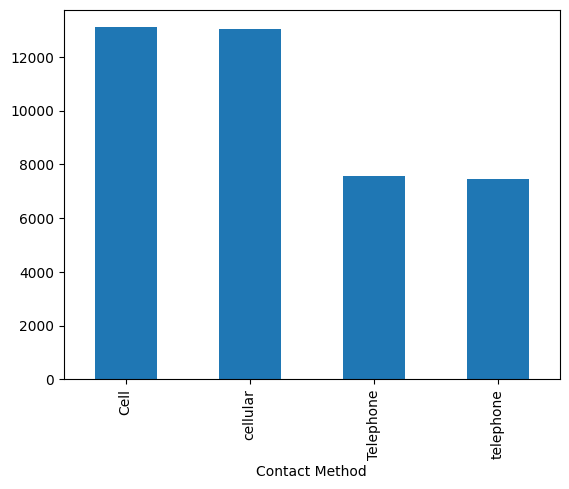

In [24]:
df["Contact Method"].value_counts()
df["Contact Method"].value_counts().plot(kind='bar')

##### Data Understanding & Insights for Campaign Calls
This feature has zero missing values.\
By looking at the output from the describe function, we can make some interesting insights:\
-The maximum value is 56 calls, meaning there are some outliers with heavy-contact\
-The minimum value is -41 calls, which is definitely an error as it is impossible to have negative calls\
\
Upon closer inspection, there are multiple values in this feature with a negative value.\
These invalid values need to be handled later by adjusting rows where the "Campaign Calls" is less than zero.

In [25]:
display(df["Campaign Calls"].value_counts())
display(df["Campaign Calls"].describe())

Campaign Calls
 1     15874
 2      9446
 3      4807
 4      2405
-1      1768
       ...  
 56        1
-41        1
 39        1
 37        1
-25        1
Name: count, Length: 70, dtype: int64

count    41188.000000
mean         2.051374
std          3.171345
min        -41.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: Campaign Calls, dtype: float64

In [26]:
display(df["Campaign Calls"].value_counts().sort_index(ascending=False).head(10))
display(df["Campaign Calls"].value_counts().sort_index(ascending=False).tail(10))

Campaign Calls
56    1
43    2
42    2
40    2
39    1
37    1
35    3
34    3
33    4
32    3
Name: count, dtype: int64

Campaign Calls
-20    3
-21    2
-22    3
-23    5
-25    1
-28    2
-29    1
-32    1
-35    2
-41    1
Name: count, dtype: int64

##### Data Understanding & Insights for Previous Contact Days
This feature has zero missing values.\
Majority of the values in this feature are "999"\
The project guide has stated that "999" means there has been no previous contact\
However leaving this as a numerical value of 999 will heavily skew and distort the actual statistics.\
Hence, we will create a different feature to address this later.

In [27]:
display(df["Previous Contact Days"].value_counts().sort_index(ascending=False).head(10))
display(df["Previous Contact Days"].value_counts().sort_index(ascending=False).tail(10))

Previous Contact Days
999    39673
27         1
26         1
25         1
22         3
21         2
20         1
19         3
18         7
17         8
Name: count, dtype: int64

Previous Contact Days
9     64
8     18
7     60
6    412
5     46
4    118
3    439
2     61
1     26
0     15
Name: count, dtype: int64

#### Further Insights for the distribuiton of Subscription Status

Looking further into this feature, we can see that the no to yes ratio nearly reaches a 9:1.\
This shows that this dataset is heavily imbalanced and skewed.\
When training our models during the pipeline, we definitely take some factors into consideration, such as:\
-Proper sampling\
-Approriate metrics\
-Assigning weights to the data

In [28]:
df["Subscription Status"].value_counts()
percentage_wise=df["Subscription Status"].value_counts()/df.shape[0]*100
print(percentage_wise)

Subscription Status
no     88.734583
yes    11.265417
Name: count, dtype: float64


### (3) Handling the null values / incorrect values / outliers 

In order to convert the string inside the "Age" column into integer values, we must do the following:

In [29]:
df["Age_numerical"]=(df["Age"].str.replace('years', '', regex=False).astype('int'))

For this next part, we addressed the outlier age of "150", by imputing the value using the median age. Firstly, we care commonly taught to drop the values if it is 5% of the total number of observations. However the total number of instances where the age is equal to 150 is ~10%, hence we decided on using imputation of values. Next we had to choose between median and mean imputation. Median imputation was chosen as the ages goes all the way up to 98 and median is more stable than mean, as it will not skew the cleaned dataset as much.

In [30]:
df_150=df[df["Age"]=="150 years"]
print(df_150.head(50))

     Client ID        Age     Occupation Marital Status      Education Level  \
7        23758  150 years         admin.       divorced    university.degree   
13       21872  150 years         admin.        married    university.degree   
17       17689  150 years     technician        married  professional.course   
51       38203  150 years        retired        married          high.school   
59       29732  150 years    blue-collar        married             basic.4y   
61        4501  150 years         admin.         single    university.degree   
67        1632  150 years         admin.        married          high.school   
73       35637  150 years       services         single          high.school   
77       24445  150 years         admin.         single          high.school   
82        4244  150 years    blue-collar        married             basic.4y   
83       13927  150 years       services         single          high.school   
89        8086  150 years    blue-collar

In [31]:
df["Age_Invalid"] = (df["Age_numerical"] == 150).astype('int')
valid_median_age=df.loc[df["Age_numerical"]!=150,"Age_numerical"].median()
df.loc[df["Age_numerical"]==150,"Age_numerical"]= valid_median_age
#df=df.drop(columns=["Age"])
df["Age_numerical"].describe()

count    41188.000000
mean        39.818928
std          9.909692
min         17.000000
25%         33.000000
50%         38.000000
75%         46.000000
max         98.000000
Name: Age_numerical, dtype: float64

For the next few columns:\
-Occupation\
-Marital Status\
-Education Level\
-Credit Default\
\
We decided to leave these columns as it is. There are no missing values from these columns, and although there is an "uknown" value inside these columns, they are still valuable insights and will be kept.

#### This is because these features will affect the client and whether or not they will subscribe to the term deposit, and I will give my reasonings below:
Occupation: Different jobs and careers, will affect the amount of money said client is currently making. For example, a person working in a management job is generally going to earn more than person working in a blue-collar job. Hence, for the person working in management, this can influence their financial decisions as having a higher discretionary income means that there is more savings and can be put towards other activities. However, for the person working a blue-collar job, they might have a lower discretionary income and hence subscribing to a term deposit might not be a consideration for them as it is lower on their priority list, or they might not have the disposable income to do so.\
\
Marital Status: As I have said earlier during the initial understandings, marital status can definitely influence financial decisions due to differing priorities and interests. For example, if the client is married, there is a higher chance that they would be paying for their mortgage or saving money towards retirement or even their children's education. Hence it is still an important feature.\
\
Education Level: Continuing from my point earlier about education generally correlating with income and financial literacy, this shows how their financial decisions could be shaped, such as a client with a higher education level being able to better understand and use these structured savings programmes such as the term deposit, and will be able to decide for themselves whether it is a good decision or not.\
\
Credit Default: No credit default can indicate that the client has financial stability and is more responisble with their money, which can affect their decision on whether they should or should not subscribe. The "unknown" class in this data indicate that the client has not have borrowed money from this bank before or the record could be incomplete. It is still an important factor which can contribute to the client's decision making.

#### Cleaning of the "Housing Loan" Feature
When inspecting the "Housing Loan" column, we can see that there are 3 different categories, "yes", "no", "unknown" and null values as "None".\
However, "None" and "no" do not mean the same thing in this case. "no" most likely refers to the client not having any housing loans, while "None" means that the bank has never recorded down the status of the client's housing loans, hence we are not able to verify whether they have or do not have any housing loans.\
We have decided to leave unknown here alone even though it constitutes to a very small minority of the data as our models can assign weights to handle this category.\
We will fill the "None" values with "no_info" to standardize.

In [32]:
df[df["Housing Loan"].isna()].head(15)

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Age_numerical,Age_Invalid
4,14021,27 years,housemaid,married,high.school,no,None,no,Cell,2,999,no,27,0
5,17202,58 years,retired,married,professional.course,no,None,yes,Cell,1,999,no,58,0
8,10822,24 years,entrepreneur,married,university.degree,no,None,None,telephone,4,999,no,24,0
10,32312,34 years,blue-collar,married,basic.9y,no,None,no,Cell,3,999,no,34,0
12,13596,43 years,blue-collar,single,basic.9y,no,None,no,cellular,1,999,yes,43,0
14,16736,58 years,blue-collar,married,basic.4y,no,None,yes,cellular,3,999,no,58,0
17,17689,150 years,technician,married,professional.course,no,None,yes,cellular,-11,999,no,38,1
18,15508,37 years,entrepreneur,single,professional.course,no,None,no,cellular,2,999,no,37,0
20,17268,59 years,retired,married,basic.9y,unknown,None,no,cellular,3,999,yes,59,0
21,1671,49 years,unemployed,single,professional.course,unknown,None,no,telephone,2,999,no,49,0


In [33]:
df[df["Housing Loan"]=="no"].head(15)

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Age_numerical,Age_Invalid
0,32885,57 years,technician,married,high.school,no,no,yes,Cell,1,999,no,57,0
2,32207,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no,33,0
3,9404,36 years,admin.,married,high.school,no,no,no,Telephone,4,999,no,36,0
13,21872,150 years,admin.,married,university.degree,no,no,no,Cell,3,999,yes,38,1
24,20771,51 years,management,married,high.school,unknown,no,no,Cell,1,999,no,51,0
31,36563,69 years,entrepreneur,married,high.school,no,no,no,cellular,2,999,yes,69,0
38,8726,30 years,blue-collar,married,basic.6y,no,no,no,telephone,2,999,no,30,0
39,25810,30 years,management,married,university.degree,no,no,no,Cell,5,999,no,30,0
64,40577,33 years,technician,single,professional.course,no,no,no,Cell,1,999,no,33,0
70,18429,47 years,admin.,married,high.school,unknown,no,yes,Telephone,-5,999,no,47,0


In [34]:
df[df["Housing Loan"]=="unknown"].head(15)

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Age_numerical,Age_Invalid
169,36548,50 years,admin.,single,basic.9y,no,unknown,unknown,Cell,1,999,yes,50,0
211,14241,27 years,blue-collar,single,basic.9y,no,unknown,unknown,Cell,3,999,no,27,0
244,14423,32 years,admin.,single,university.degree,no,unknown,unknown,Cell,3,999,no,32,0
401,31694,38 years,technician,married,university.degree,no,unknown,unknown,Cell,-1,999,no,38,0
404,6661,54 years,admin.,married,high.school,no,unknown,unknown,telephone,1,999,no,54,0
468,9332,40 years,admin.,married,university.degree,unknown,unknown,unknown,telephone,6,999,no,40,0
804,15179,29 years,unemployed,married,university.degree,no,unknown,unknown,cellular,2,999,no,29,0
860,26664,34 years,unemployed,married,high.school,no,unknown,unknown,Cell,2,999,no,34,0
906,19859,49 years,technician,married,professional.course,unknown,unknown,unknown,Cell,2,999,no,49,0
952,20069,43 years,admin.,married,university.degree,no,unknown,unknown,cellular,2,999,no,43,0


In [35]:
df["Housing Loan"]=df["Housing Loan"].fillna("no_info")
display(df["Housing Loan"].isna().value_counts())
display(df["Housing Loan"].value_counts())

Housing Loan
False    41188
Name: count, dtype: int64

Housing Loan
no_info    24789
yes         8595
no          7411
unknown      393
Name: count, dtype: int64

Similar to the "Housing Loan" column, there are 3 different categories, "yes", "no", "unknown" and null values as "None".\
However, "None" and "no" do not mean the same thing in this case. "no" most likely refers to the client not having any personal loans, while "None" means that the bank has never recorded down the status of the client's personal loans, hence we are not able to verify whether they have or do not have any personal loans.\
We have decided to leave unknown here alone even though it constitutes to a very small minority of the data as our models can assign weights to handle this category.\
We will fill the "None" values with "no_info" to standardize.

In [36]:
display(df[df["Personal Loan"].isna()].head(5))
display(df[df["Personal Loan"]=="no"].head(5))
df[df["Personal Loan"]=="unknown"].head(5)

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Age_numerical,Age_Invalid
7,23758,150 years,admin.,divorced,university.degree,unknown,yes,None,Cell,7,999,no,38,1
8,10822,24 years,entrepreneur,married,university.degree,no,no_info,None,telephone,4,999,no,24,0
58,39197,41 years,admin.,divorced,university.degree,no,yes,None,Cell,2,6,yes,41,0
63,3420,45 years,blue-collar,married,basic.4y,no,no_info,None,Telephone,3,999,no,45,0
80,33318,41 years,management,married,high.school,unknown,yes,None,Cell,2,999,no,41,0


,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Age_numerical,Age_Invalid
1,3170,55 years,unknown,married,unknown,unknown,yes,no,telephone,2,999,no,55,0
2,32207,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no,33,0
3,9404,36 years,admin.,married,high.school,no,no,no,Telephone,4,999,no,36,0
4,14021,27 years,housemaid,married,high.school,no,no_info,no,Cell,2,999,no,27,0
6,880,48 years,services,married,high.school,unknown,yes,no,Telephone,1,999,no,48,0


,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Age_numerical,Age_Invalid
164,13416,150 years,technician,married,university.degree,no,no_info,unknown,Telephone,1,999,no,38,1
169,36548,50 years,admin.,single,basic.9y,no,unknown,unknown,Cell,1,999,yes,50,0
188,8815,30 years,technician,single,professional.course,no,no_info,unknown,telephone,1,999,no,30,0
211,14241,27 years,blue-collar,single,basic.9y,no,unknown,unknown,Cell,3,999,no,27,0
212,24204,150 years,unemployed,married,university.degree,no,no_info,unknown,Cell,1,999,no,38,1


In [37]:
display(df["Personal Loan"].isna().sum())
df["Personal Loan"]=df["Personal Loan"].fillna("no_info")
display(df["Personal Loan"].isna().value_counts())
display(df["Personal Loan"].value_counts())

np.int64(4146)

Personal Loan
False    41188
Name: count, dtype: int64

Personal Loan
no         30532
yes         5633
no_info     4146
unknown      877
Name: count, dtype: int64

#### Cleaning of the "Contact Method" Feature
When inspecting the "Contact Method" column, we can see that there are 4 different categories, "Cell", "cellular", "Telephone" and "telephone".\
To clean this, we will convert them into similar, lowercase terms:\
"Telephone" & "telephone" --> "telephone"\
"Cell" & "cellular" --> "cellular"

In [38]:
df["Contact Method"].value_counts()

Contact Method
Cell         13100
cellular     13044
Telephone     7585
telephone     7459
Name: count, dtype: int64

In [39]:
df["Contact Method"]= df["Contact Method"].replace({"Cell":"cellular", "Telephone":"telephone"})
df["Contact Method"].value_counts()

Contact Method
cellular     26144
telephone    15044
Name: count, dtype: int64

#### Cleaning of the "Campaign Calls" Feature
When inspecting the "Campaign" column, we can see that there are many values that are negative.\
To clean this, we must first check the number of negative values, before we make a decision.

In [40]:
df[df["Campaign Calls"]<0].shape[0]

4153

After looking at the values, ~10% of the data is less than 0, so it is not wise to drop these rows.\
Instead, we decided to impute the values, similar to what we did for the cleaing of the "Age" column.\


In [41]:
df["Calls_Invalid"] = (df["Campaign Calls"] <0)
valid_median_calls=df.loc[df["Campaign Calls"]>=0,"Campaign Calls"].median()
df.loc[df["Campaign Calls"]<0,"Campaign Calls"]= valid_median_calls
display(df["Campaign Calls"].describe())
display(df["Calls_Invalid"].value_counts())

count    41188.000000
mean         2.511144
std          2.626284
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: Campaign Calls, dtype: float64

Calls_Invalid
False    37035
True      4153
Name: count, dtype: int64

#### Cleaning of the "Previous Contact Days" Feature
As seen in the project guide, values like "999" are placeholders for "No previous contact".\
Hence, we cannot treat this as a numeric value, or it will skew the other data.\
We decided to replace 999 with NaN and create a new column with binary features to show whether there has been contact or not, using "1" and "0".\
This helps to remove any instances which could heavily imbalance our data, and still preserve the knowledge of knowing which clients have had contact or no previous contact.\
Keeping this information is extremely important for our project, as it can influence a person's decision.

In [42]:
df["no_previous_contact"] = (df["Previous Contact Days"] == 999)
df["Previous Contact Days_clean"]= df["Previous Contact Days"].replace(999, np.nan)

In [43]:
display(df["Previous Contact Days"].head())
display(df["no_previous_contact"].head())
display(df["Previous Contact Days_clean"].head())

0    999
1    999
2    999
3    999
4    999
Name: Previous Contact Days, dtype: int64

0    True
1    True
2    True
3    True
4    True
Name: no_previous_contact, dtype: bool

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: Previous Contact Days_clean, dtype: float64

In [44]:
df.head()

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Age_numerical,Age_Invalid,Calls_Invalid,no_previous_contact,Previous Contact Days_clean
0,32885,57 years,technician,married,high.school,no,no,yes,cellular,1,999,no,57,0,False,True,NaN
1,3170,55 years,unknown,married,unknown,unknown,yes,no,telephone,2,999,no,55,0,False,True,NaN
2,32207,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no,33,0,False,True,NaN
3,9404,36 years,admin.,married,high.school,no,no,no,telephone,4,999,no,36,0,False,True,NaN
4,14021,27 years,housemaid,married,high.school,no,no_info,no,cellular,2,999,no,27,0,False,True,NaN
